# 2P3G New-Goal Distance Analysis

Compute distances at the exact moment a new goal appears, then plot histograms by condition and RL type.


## Load + helpers

We reconstruct positions at the new-goal moment from raw columns to ensure correctness:
- Human position at step `int(newGoalPresentedTime)` using `player1Trajectory` (fallback to init + actions).
- AI position at the same moment using `player2Trajectory` positions taken after each human step. We primarily select the sequence of odd indices (AI updates after human moves) and index by `step`; if unavailable we clamp or fallback to `2*step-1` in the raw trajectory.
- Old goal (shared goal) is read from `player1CurrentGoal` or `player2CurrentGoal` at index `step-1` (first non-null), mapping `0 -> target1`, `1 -> target2`.

From these, we compute five variables:
`newGoalDistanceToPlayer1`, `newGoalDistanceToPlayer2`, `humanDistanceToOldGoal`, `aiDistanceToOldGoal`, `newGoalDistanceSum`.

In [11]:
from pathlib import Path
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')
DATA_DIR = Path('data_analysis')
DATA_FILE = DATA_DIR / 'experimental_conditions_data.csv'

def parse_point(value):
    if value is None:
        return None
    s = str(value).strip()
    if s == '' or s in {'[]'}:
        return None
    if s.lower() in {'nan', 'none', 'null'}:
        return None
    return tuple(ast.literal_eval(s))

def parse_positions(value):
    if value is None:
        return []
    s = str(value).strip()
    if s == '' or s == '[]':
        return []
    return [tuple(x) for x in ast.literal_eval(s)]

def compress_positions(seq):
    out = []
    for p in seq:
        if not out or p != out[-1]:
            out.append(p)
    return out

def get_human_pos_at_new(row):
    step_val = row.get('newGoalPresentedTime')
    if step_val in (None, ''):
        return None
    step = int(float(step_val))
    traj = parse_positions(row.get('player1Trajectory'))
    if step < len(traj):
        return traj[step]
    # fallback: reconstruct from init + actions
    pos = parse_point(row.get('initPlayerGrid'))
    for idx, act in enumerate(parse_positions(row.get('player1Actions')), start=1):
        pos = (pos[0] + act[0], pos[1] + act[1])
        if idx == step:
            return pos
    return pos

def get_ai_pos_at_new(row):
    step_val = row.get('newGoalPresentedTime')
    if step_val in (None, ''):
        return None
    step = int(float(step_val))
    traj = parse_positions(row.get('player2Trajectory'))
    if not traj:
        return parse_point(row.get('initAIGrid'))
    # Prefer AI state after each human step: odd indices 1,3,5,...
    odd_positions = [traj[i] for i in range(1, len(traj), 2)]
    if odd_positions:
        idx = min(step, len(odd_positions)-1)
        return odd_positions[idx]
    # Fallback: clamp 2*step-1 into raw trajectory
    idx = max(0, min(len(traj)-1, 2*step - 1))
    return traj[idx]

def get_goal_index_at_new(row, step):
    # Check player1CurrentGoal then player2CurrentGoal for a non-null index
    for col in ('player1CurrentGoal', 'player2CurrentGoal'):
        raw = row.get(col)
        if not raw:
            continue
        raw = str(raw).replace('null', 'None')
        try:
            arr = ast.literal_eval(raw)
        except Exception:
            continue
        if not isinstance(arr, list) or not arr:
            continue
        idx = max(0, min(step-1, len(arr)-1))
        val = arr[idx]
        if val is not None:
            try:
                return int(val)
            except Exception:
                pass
    return 0

def manhattan(a, b):
    if a is None or b is None:
        return np.nan
    return abs(a[0]-b[0]) + abs(a[1]-b[1])

raw = pd.read_csv('experimental_conditions_data.csv')
df = (
    raw.query("experimentType == '2P3G' and newGoalPresented == True").copy()
)

# Compute positions
human_pos = []
ai_pos = []
old_goals = []
new_goals = []
for i, row in df.iterrows():
    step = int(float(row['newGoalPresentedTime'])) if pd.notna(row['newGoalPresentedTime']) else 0
    h = get_human_pos_at_new(row)
    a = get_ai_pos_at_new(row)
    t1 = parse_point(row.get('target1'))
    t2 = parse_point(row.get('target2'))
    gidx = get_goal_index_at_new(row, step)
    old_goal = (t1, t2)[gidx] if gidx in (0,1) else t1
    human_pos.append(h)
    ai_pos.append(a)
    old_goals.append(old_goal)
    new_goals.append(parse_point(row.get('newGoalPosition')))

df = df.assign(
    human_pos_at_new=human_pos,
    ai_pos_at_new=ai_pos,
    old_goal_at_new=old_goals,
    new_goal=new_goals,
)

# Compute the distance
df = df.assign(
    newGoalDistanceToPlayer1=df.apply(lambda r: manhattan(r['human_pos_at_new'], r['new_goal']), axis=1),
    newGoalDistanceToPlayer2=df.apply(lambda r: manhattan(r['ai_pos_at_new'], r['new_goal']), axis=1),
    humanDistanceToOldGoal=df.apply(lambda r: manhattan(r['human_pos_at_new'], r['old_goal_at_new']), axis=1),
    aiDistanceToOldGoal=df.apply(lambda r: manhattan(r['ai_pos_at_new'], r['old_goal_at_new']), axis=1),
)
df['newGoalDistanceSum'] = df['newGoalDistanceToPlayer1'] + df['newGoalDistanceToPlayer2']
df['oldGoalDistanceSum'] = df['humanDistanceToOldGoal'] + df['aiDistanceToOldGoal']

# Keep key columns for plotting
keep_cols = [
    'participantId','trialIndex','rlAgentType','distanceCondition',
    'newGoalDistanceToPlayer1','newGoalDistanceToPlayer2','humanDistanceToOldGoal','aiDistanceToOldGoal','newGoalDistanceSum'
]
plot_df = df[keep_cols].copy()
print(f"Prepared {len(plot_df)} 2P3G rows for plotting")
plot_df.head()

Prepared 532 2P3G rows for plotting


,participantId,trialIndex,rlAgentType,distanceCondition,newGoalDistanceToPlayer1,newGoalDistanceToPlayer2,humanDistanceToOldGoal,aiDistanceToOldGoal,newGoalDistanceSum
23,62faba5f904642df812944fa,0,joint,equal_to_both,5,5,6,4,10
24,62faba5f904642df812944fa,1,joint,closer_to_player1,4,8,6,4,12
25,62faba5f904642df812944fa,2,joint,closer_to_player2,7,2,5,4,9
26,62faba5f904642df812944fa,3,joint,equal_to_both,6,5,6,7,11
27,62faba5f904642df812944fa,4,joint,closer_to_player2,7,2,4,3,9


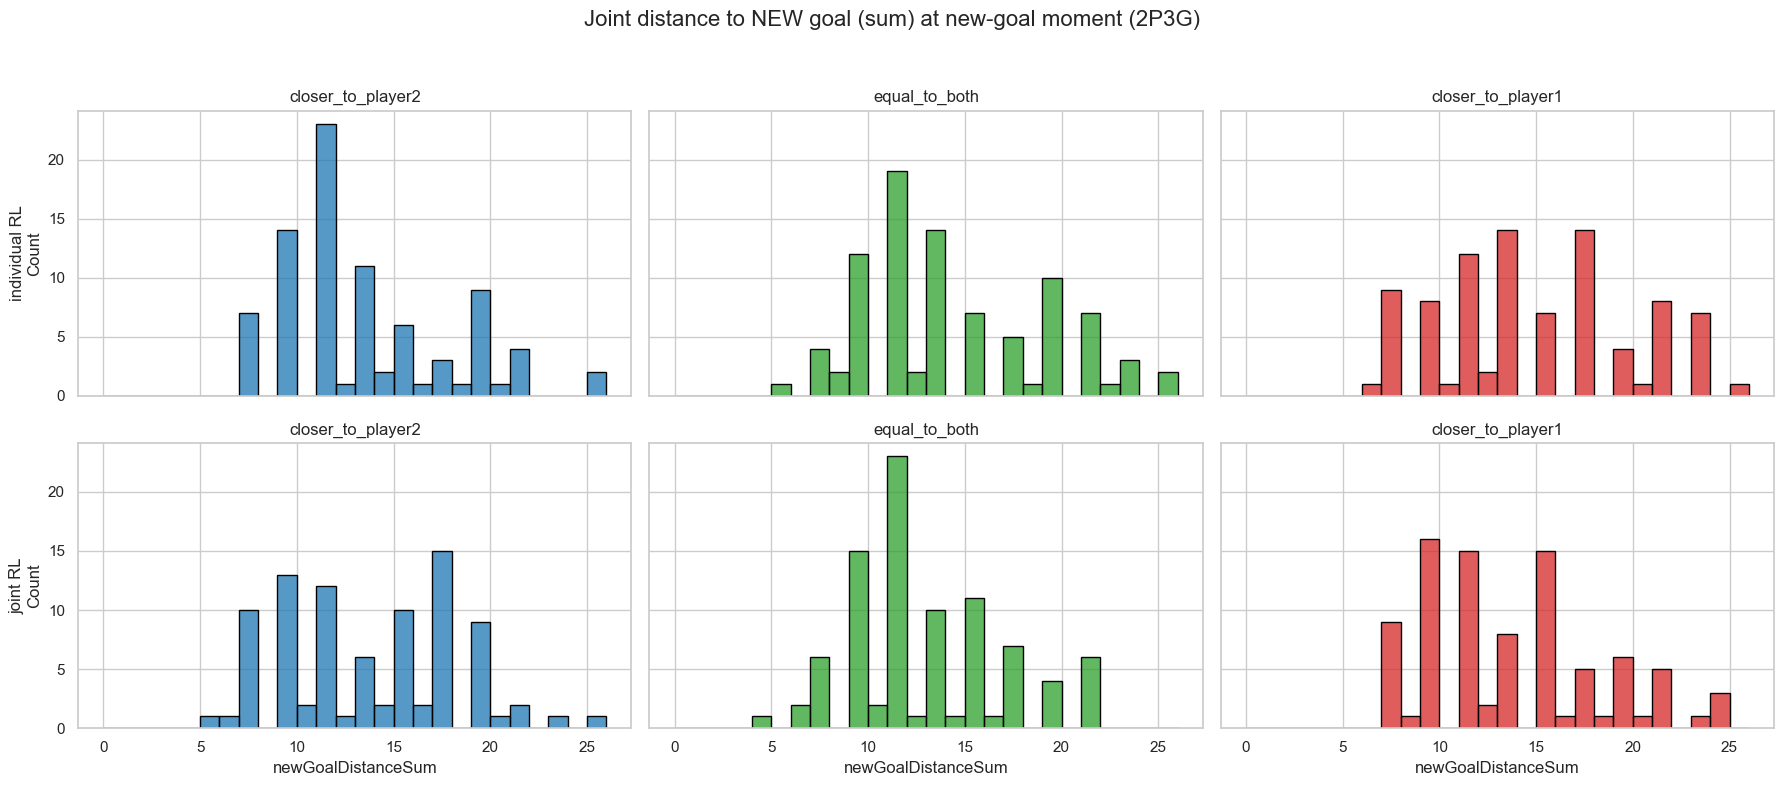

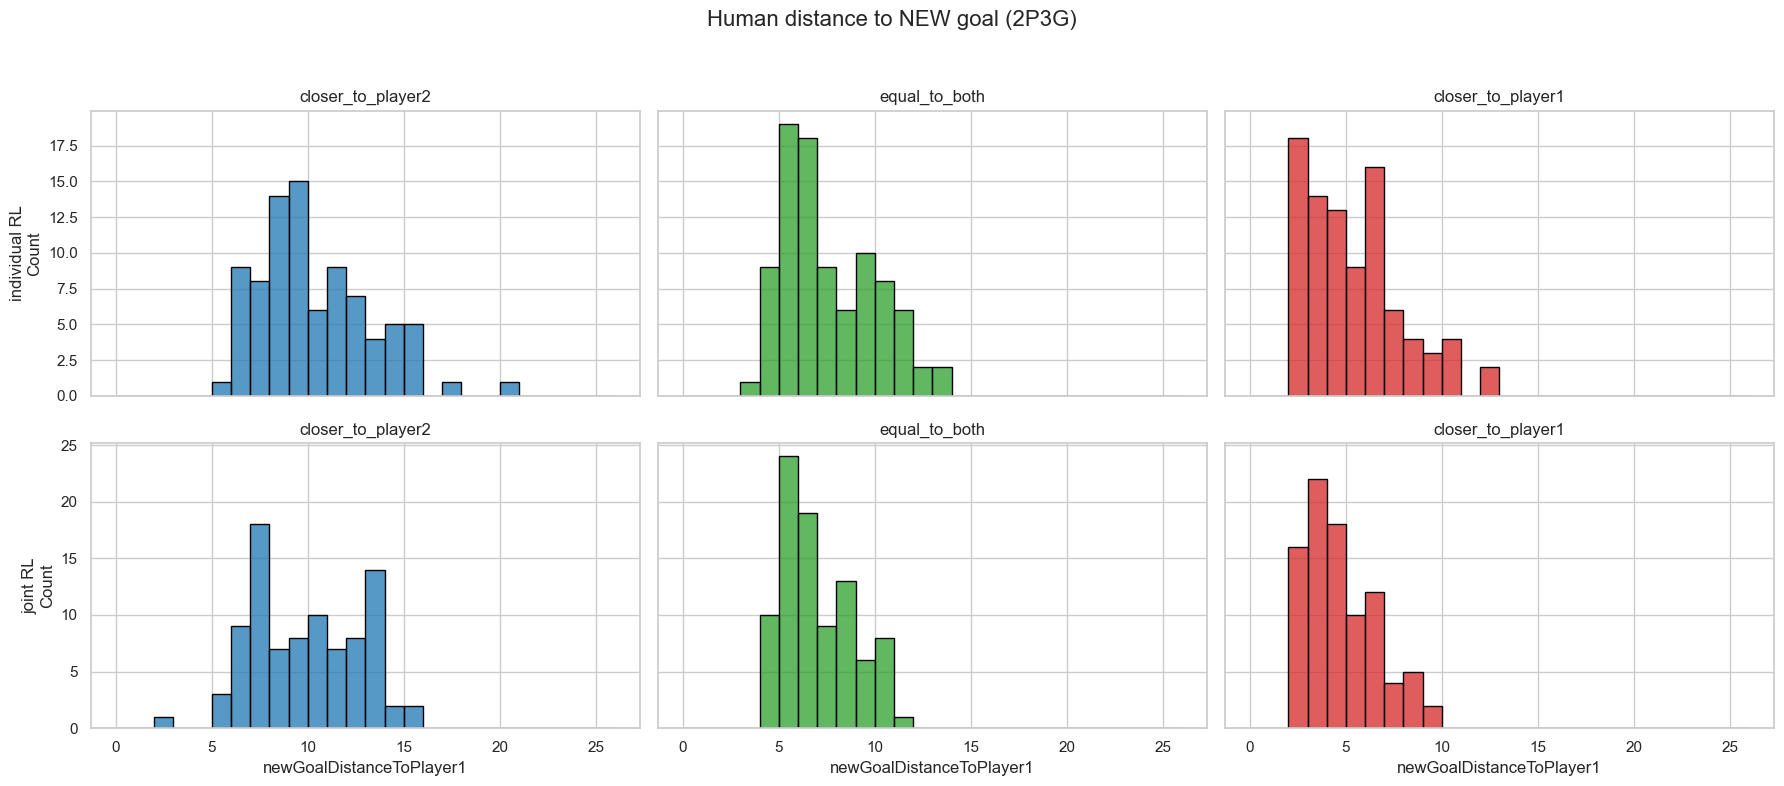

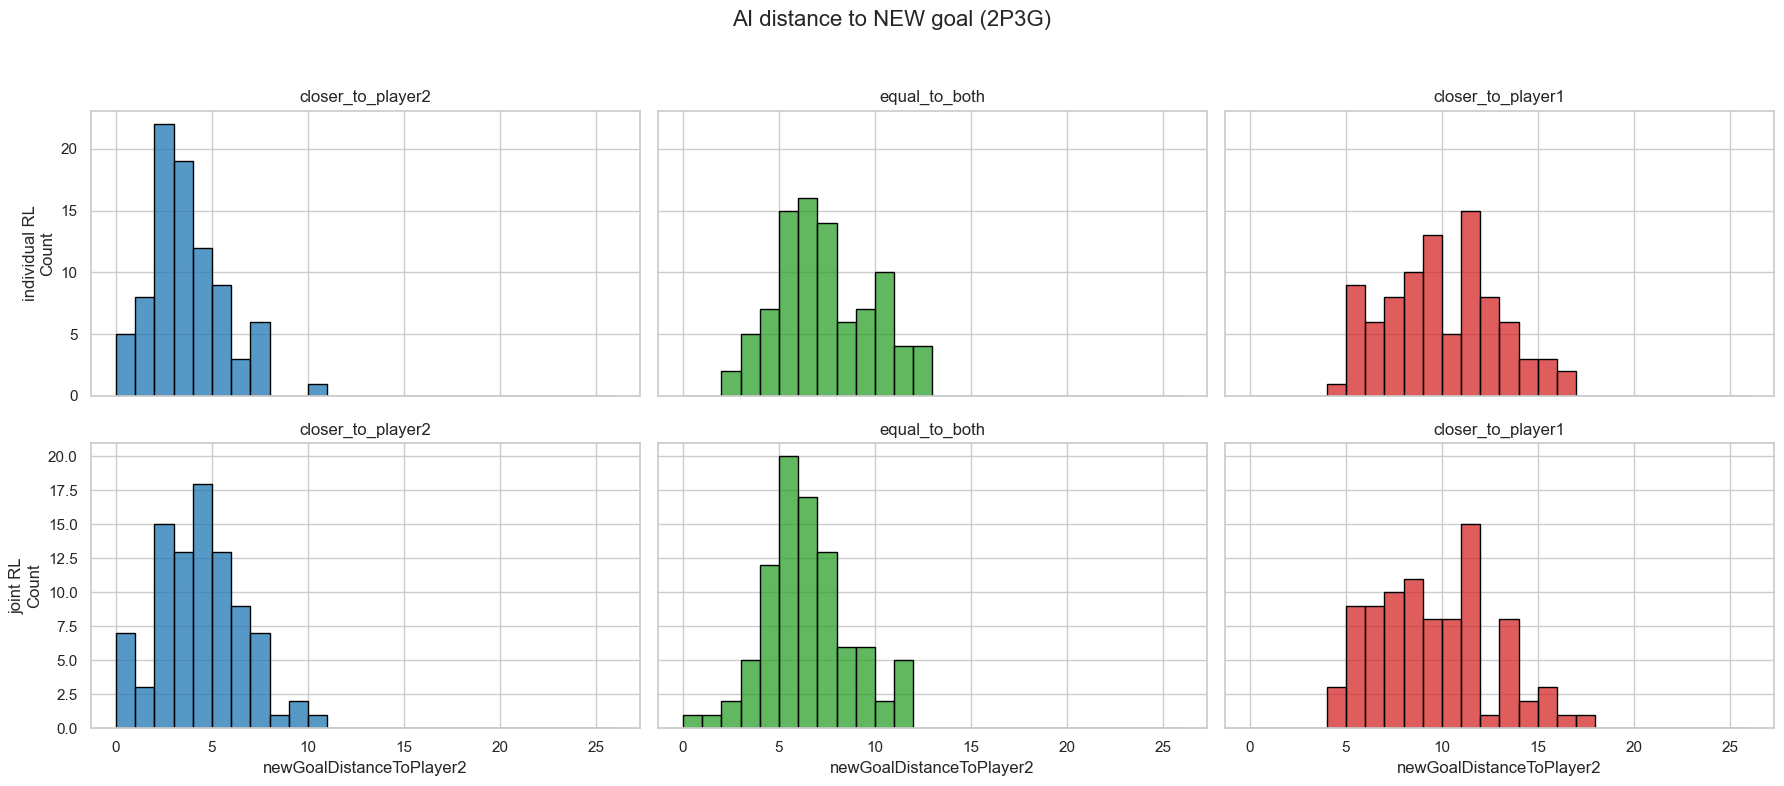

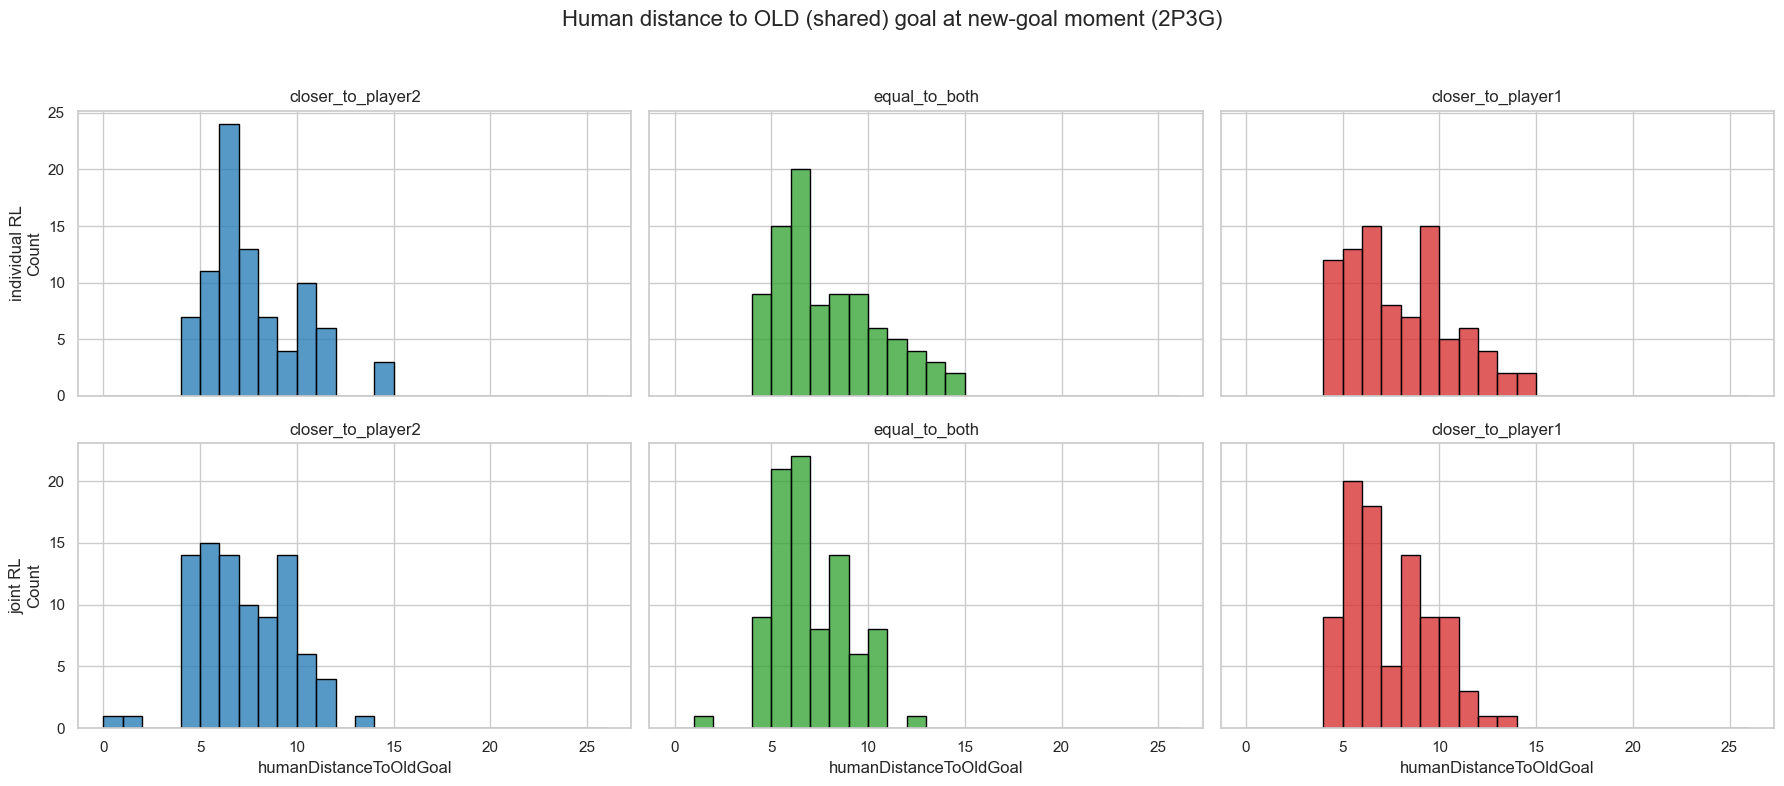

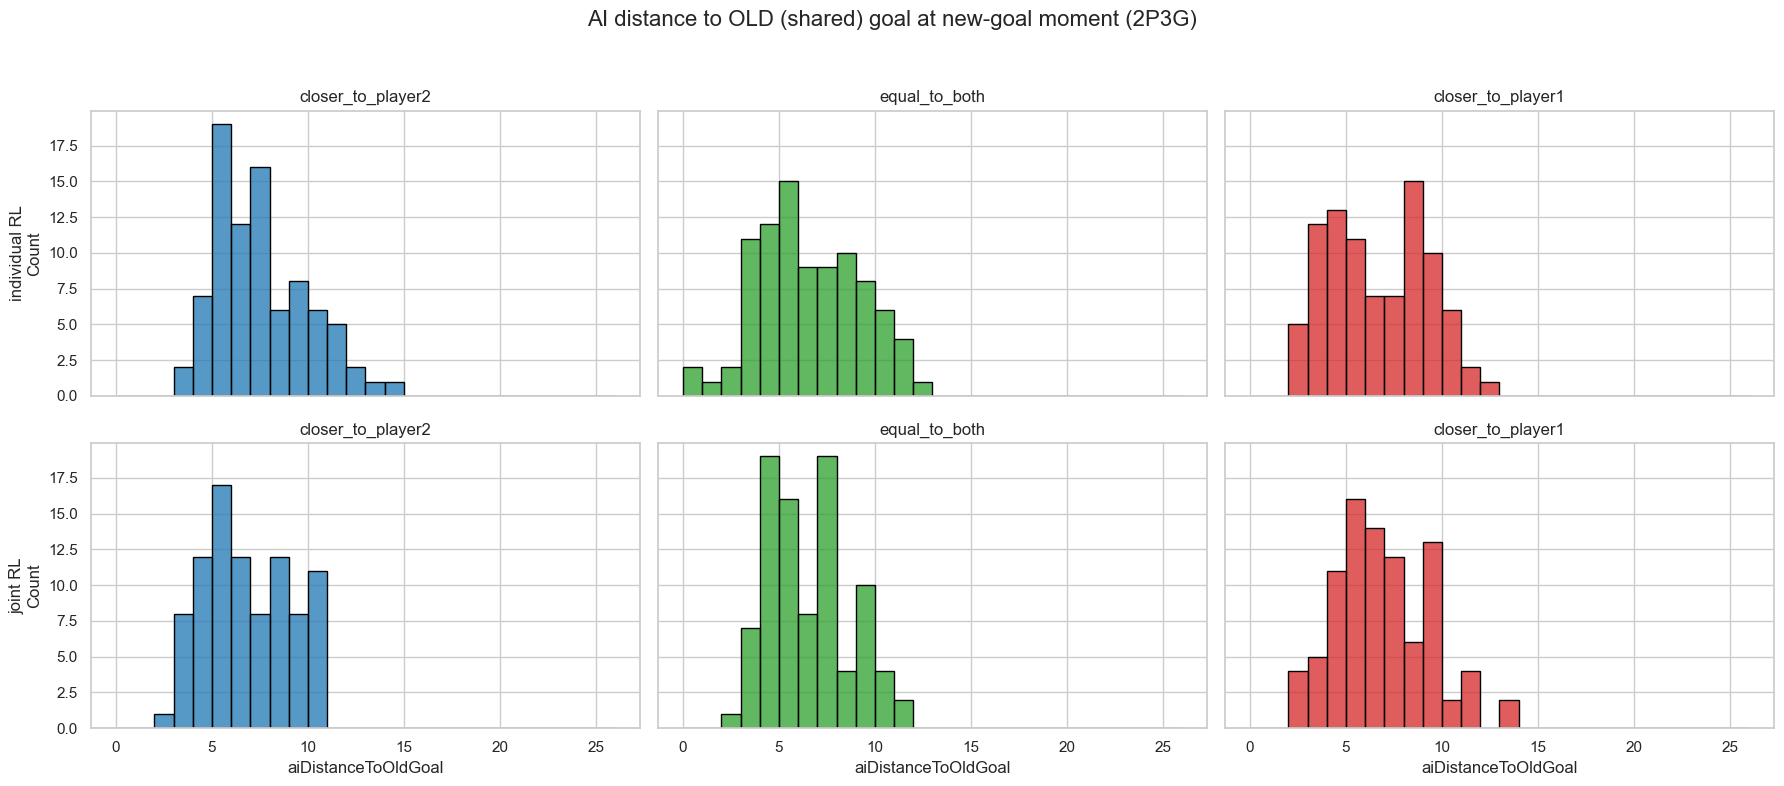

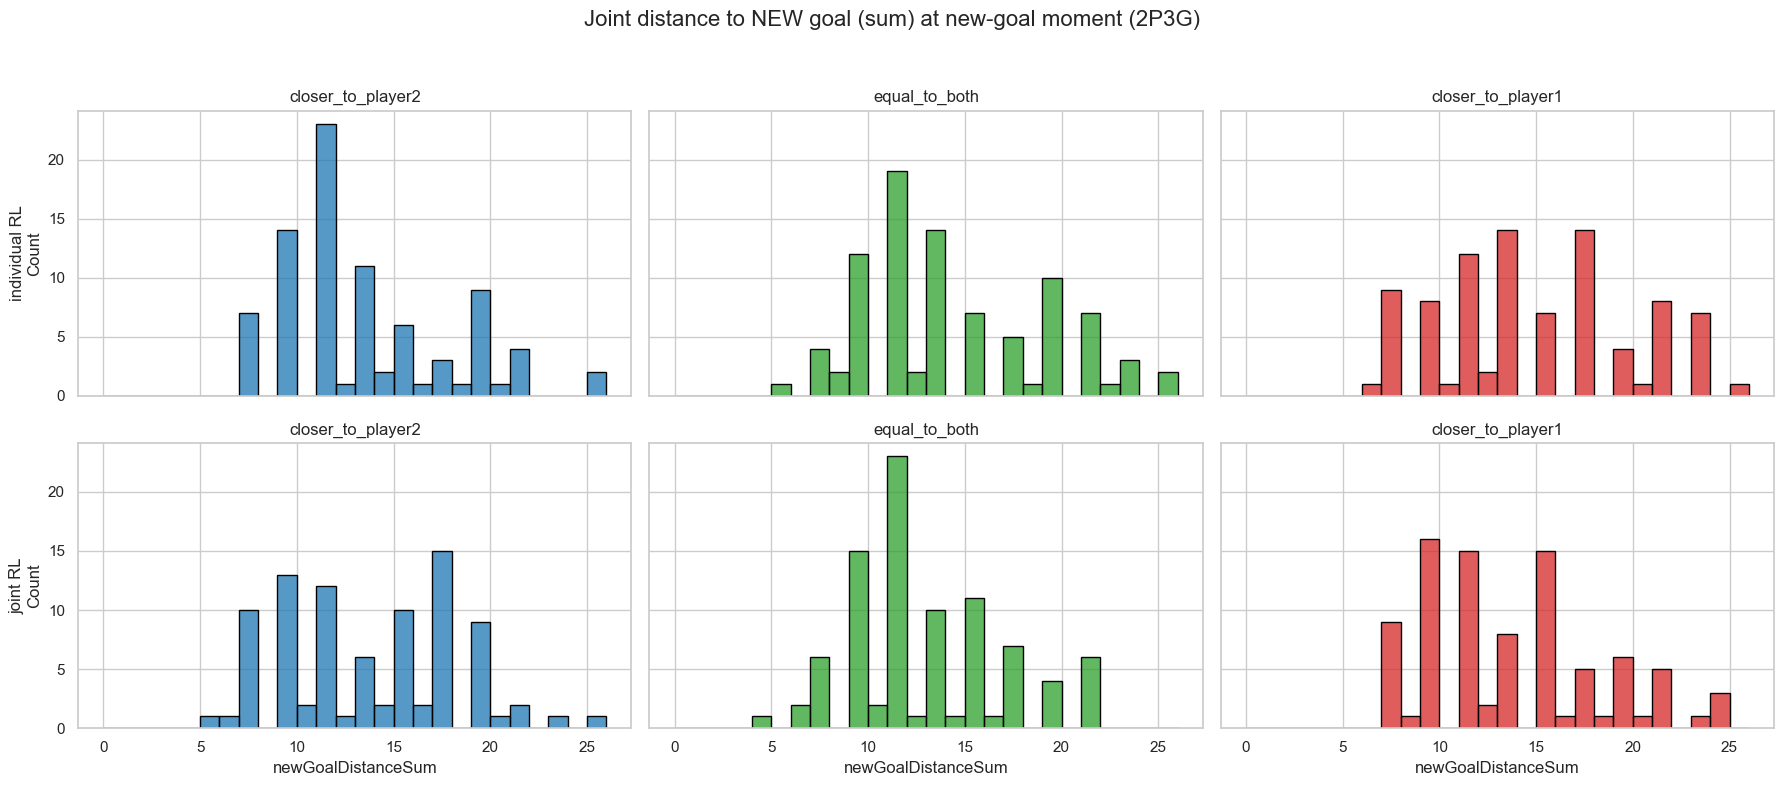

In [12]:
import numpy as np

def plot_grid(var_name, title, bins=None):
    conditions = ['closer_to_player2', 'equal_to_both', 'closer_to_player1']
    rl_types = ['individual', 'joint']
    colors = {
        'closer_to_player2': '#1f77b4',
        'equal_to_both': '#2ca02c',
        'closer_to_player1': '#d62728',
    }
    gdf = plot_df.copy()
    gdf = gdf[pd.notna(gdf[var_name])]
    fig, axes = plt.subplots(len(rl_types), len(conditions), figsize=(18, 8), sharex='col', sharey='row')
    for r, rl in enumerate(rl_types):
        sdf_rl = gdf[gdf['rlAgentType'] == rl]
        for c, cond in enumerate(conditions):
            ax = axes[r, c]
            sdf = sdf_rl[sdf_rl['distanceCondition'] == cond]
            if sdf.empty:
                ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
                ax.set_axis_off()
                continue
            sns.histplot(sdf[var_name], ax=ax, bins=bins, color=colors[cond], edgecolor='black')
            ax.set_title(cond)
            if c == 0:
                ax.set_ylabel(f'{rl} RL\nCount')
            else:
                ax.set_ylabel('')
            if r == len(rl_types) - 1:
                ax.set_xlabel(var_name)
            else:
                ax.set_xlabel('')
    fig.suptitle(title, fontsize=16)
    fig.tight_layout(rect=(0, 0, 1, 0.95))
    return fig

# Choose integer bins up to the max across variables for readability
max_d = int(max(
    plot_df['newGoalDistanceToPlayer1'].max(),
    plot_df['newGoalDistanceToPlayer2'].max(),
    plot_df['humanDistanceToOldGoal'].max(),
    plot_df['aiDistanceToOldGoal'].max(),
    plot_df['newGoalDistanceSum'].max()
))
bins = np.arange(0, max(1, max_d) + 1.5, 1)

plot_grid('newGoalDistanceToPlayer1', 'Human distance to NEW goal (2P3G)', bins)
plot_grid('newGoalDistanceToPlayer2', 'AI distance to NEW goal (2P3G)', bins)
plot_grid('humanDistanceToOldGoal', 'Human distance to OLD (shared) goal at new-goal moment (2P3G)', bins)
plot_grid('aiDistanceToOldGoal', 'AI distance to OLD (shared) goal at new-goal moment (2P3G)', bins)
plot_grid('newGoalDistanceSum', 'Joint distance to NEW goal (sum) at new-goal moment (2P3G)', bins)

## Histograms by condition and RL type

Each figure is a 2×3 grid: rows are RL type (`individual`, `joint`), columns are distance condition (`closer_to_player2`, `equal_to_both`, `closer_to_player1`).

## Equal-to-both: AI old vs new distance

Histogram(s) for the difference `aiDistanceToOldGoal - newGoalDistanceToPlayer2` when `distanceCondition == 'equal_to_both'`.


Rows in equal_to_both: 180


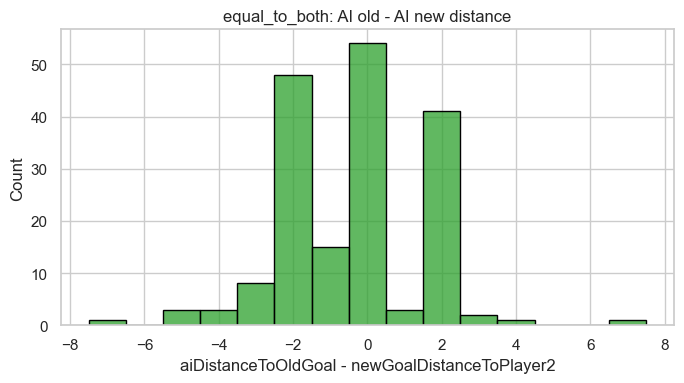

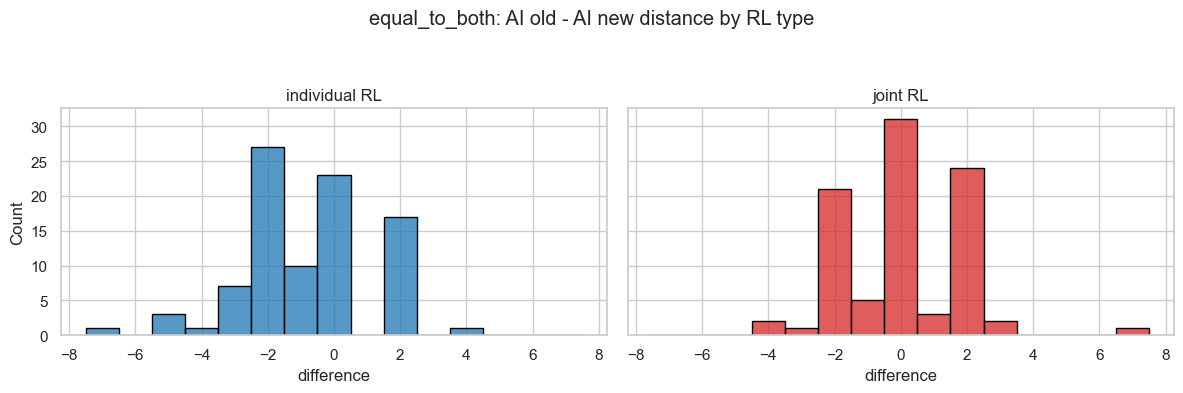

In [13]:
# Equal-to-both condition: AI old vs new distance difference
eq = plot_df.query("distanceCondition == 'equal_to_both'").copy()
eq['ai_old_minus_ai_new'] = eq['aiDistanceToOldGoal'] - eq['newGoalDistanceToPlayer2']
print(f'Rows in equal_to_both: {len(eq)}')

if not eq.empty:
    min_v = int(eq['ai_old_minus_ai_new'].min())
    max_v = int(eq['ai_old_minus_ai_new'].max())
    bins = np.arange(min_v - 0.5, max_v + 1.5, 1)

    # Overall histogram
    plt.figure(figsize=(7, 4))
    sns.histplot(eq['ai_old_minus_ai_new'], bins=bins, color='#2ca02c', edgecolor='black')
    plt.title('equal_to_both: AI old - AI new distance')
    plt.xlabel('aiDistanceToOldGoal - newGoalDistanceToPlayer2')
    plt.ylabel('Count')
    plt.tight_layout()

    # By RL type
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
    for ax, rl, color in zip(axes, ['individual', 'joint'], ['#1f77b4', '#d62728']):
        sub = eq[eq['rlAgentType'] == rl]
        if sub.empty:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
            ax.set_axis_off()
            continue
        sns.histplot(sub['ai_old_minus_ai_new'], bins=bins, color=color, edgecolor='black', ax=ax)
        ax.set_title(f'{rl} RL')
        ax.set_xlabel('difference')
    axes[0].set_ylabel('Count')
    fig.suptitle('equal_to_both: AI old - AI new distance by RL type')
    fig.tight_layout(rect=(0, 0, 1, 0.92))
else:
    print('No rows for equal_to_both')


## Joint-distance change (new vs old)

We compute `joint_distance_diff = newGoalDistanceSum - (humanDistanceToOldGoal + aiDistanceToOldGoal)` at the new-goal moment,
and plot 6 histograms (3 distance conditions × 2 RL types).


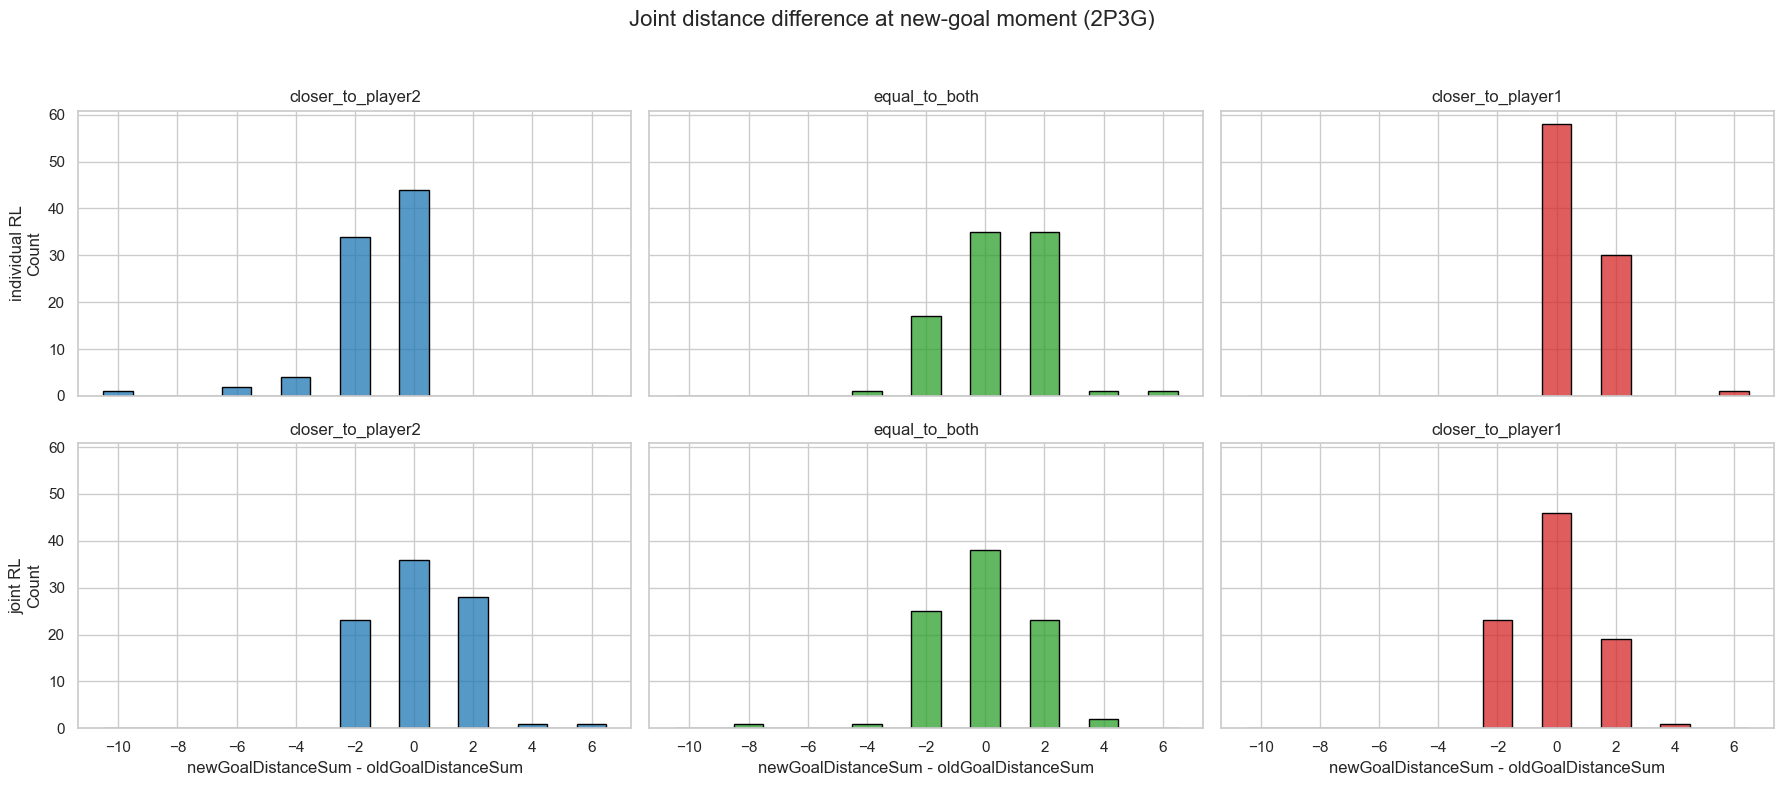

In [14]:
# Joint-distance difference: (new sum) - (old sum)
plot_df = plot_df.copy()
plot_df['oldGoalDistanceSum'] = plot_df['humanDistanceToOldGoal'] + plot_df['aiDistanceToOldGoal']
plot_df['joint_distance_diff'] = plot_df['newGoalDistanceSum'] - plot_df['oldGoalDistanceSum']

conditions = ['closer_to_player2', 'equal_to_both', 'closer_to_player1']
rl_types = ['individual', 'joint']
colors = {
    'closer_to_player2': '#1f77b4',
    'equal_to_both': '#2ca02c',
    'closer_to_player1': '#d62728',
}

# Determine integer bin edges around the observed min/max
min_v = int(plot_df['joint_distance_diff'].min()) if len(plot_df) else 0
max_v = int(plot_df['joint_distance_diff'].max()) if len(plot_df) else 1
bins = np.arange(min_v - 0.5, max_v + 1.5, 1)

fig, axes = plt.subplots(len(rl_types), len(conditions), figsize=(18, 8), sharex=True, sharey=True)
for r, rl in enumerate(rl_types):
    sdf_rl = plot_df[plot_df['rlAgentType'] == rl]
    for c, cond in enumerate(conditions):
        ax = axes[r, c]
        sdf = sdf_rl[sdf_rl['distanceCondition'] == cond]
        if sdf.empty:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
            ax.set_axis_off()
            continue
        sns.histplot(sdf['joint_distance_diff'], bins=bins, color=colors[cond], edgecolor='black', ax=ax)
        ax.set_title(cond)
        if c == 0:
            ax.set_ylabel(f'{rl} RL\nCount')
        else:
            ax.set_ylabel('')
        if r == len(rl_types) - 1:
            ax.set_xlabel('newGoalDistanceSum - oldGoalDistanceSum')
        else:
            ax.set_xlabel('')
        # Set x-axis tick spacing to 2
        ax.set_xticks(np.arange(min_v, max_v + 1, 2))
fig.suptitle('Joint distance difference at new-goal moment (2P3G)', fontsize=16)
fig.tight_layout(rect=(0, 0, 1, 0.95))


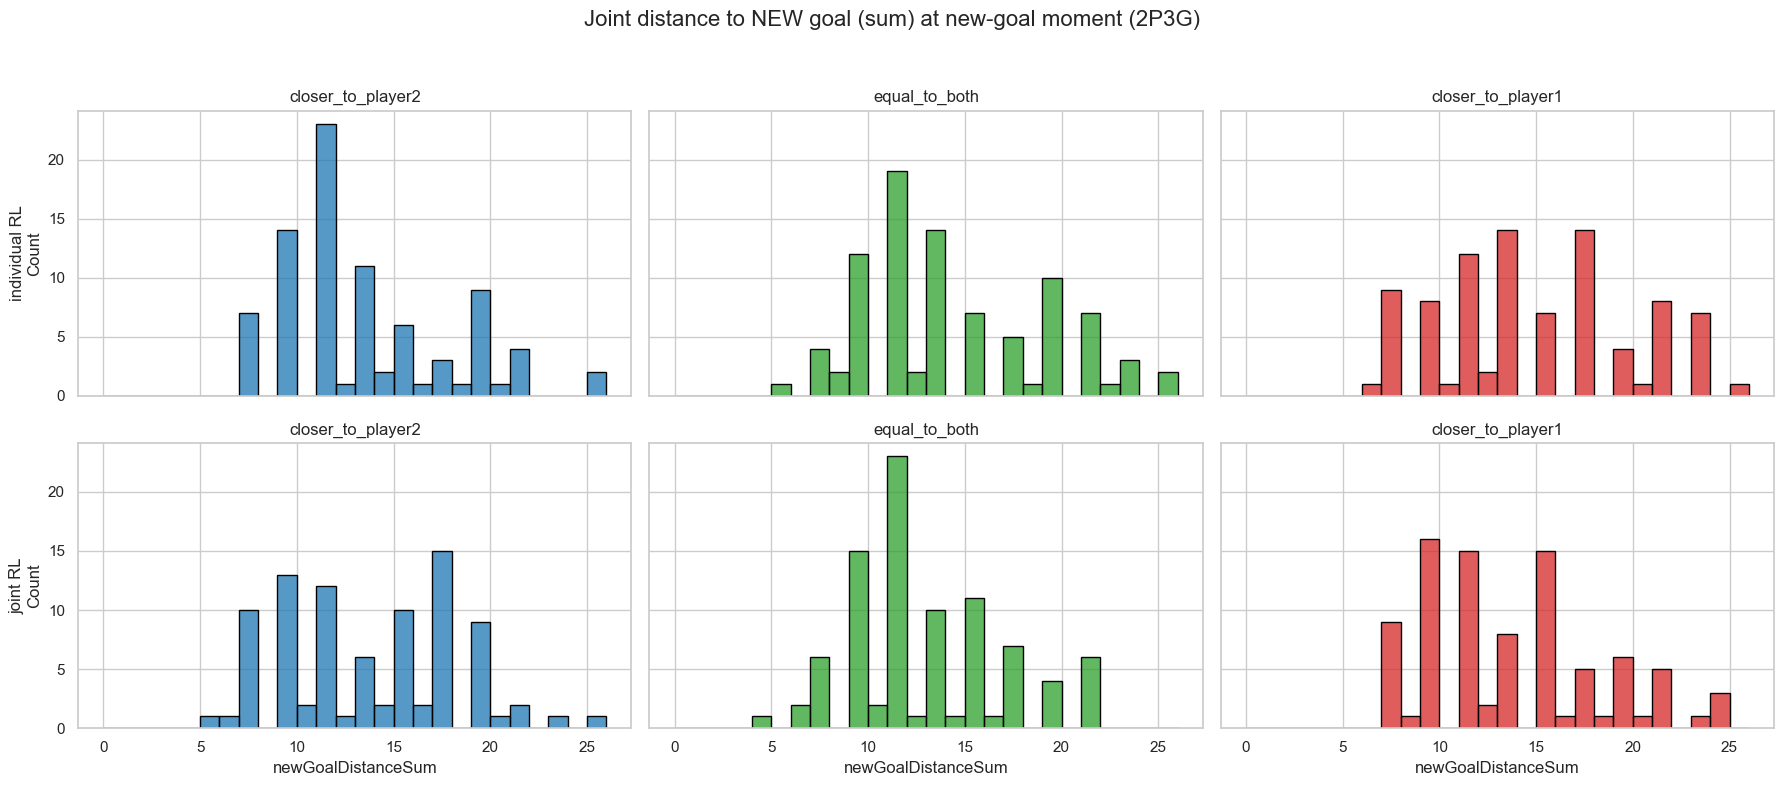

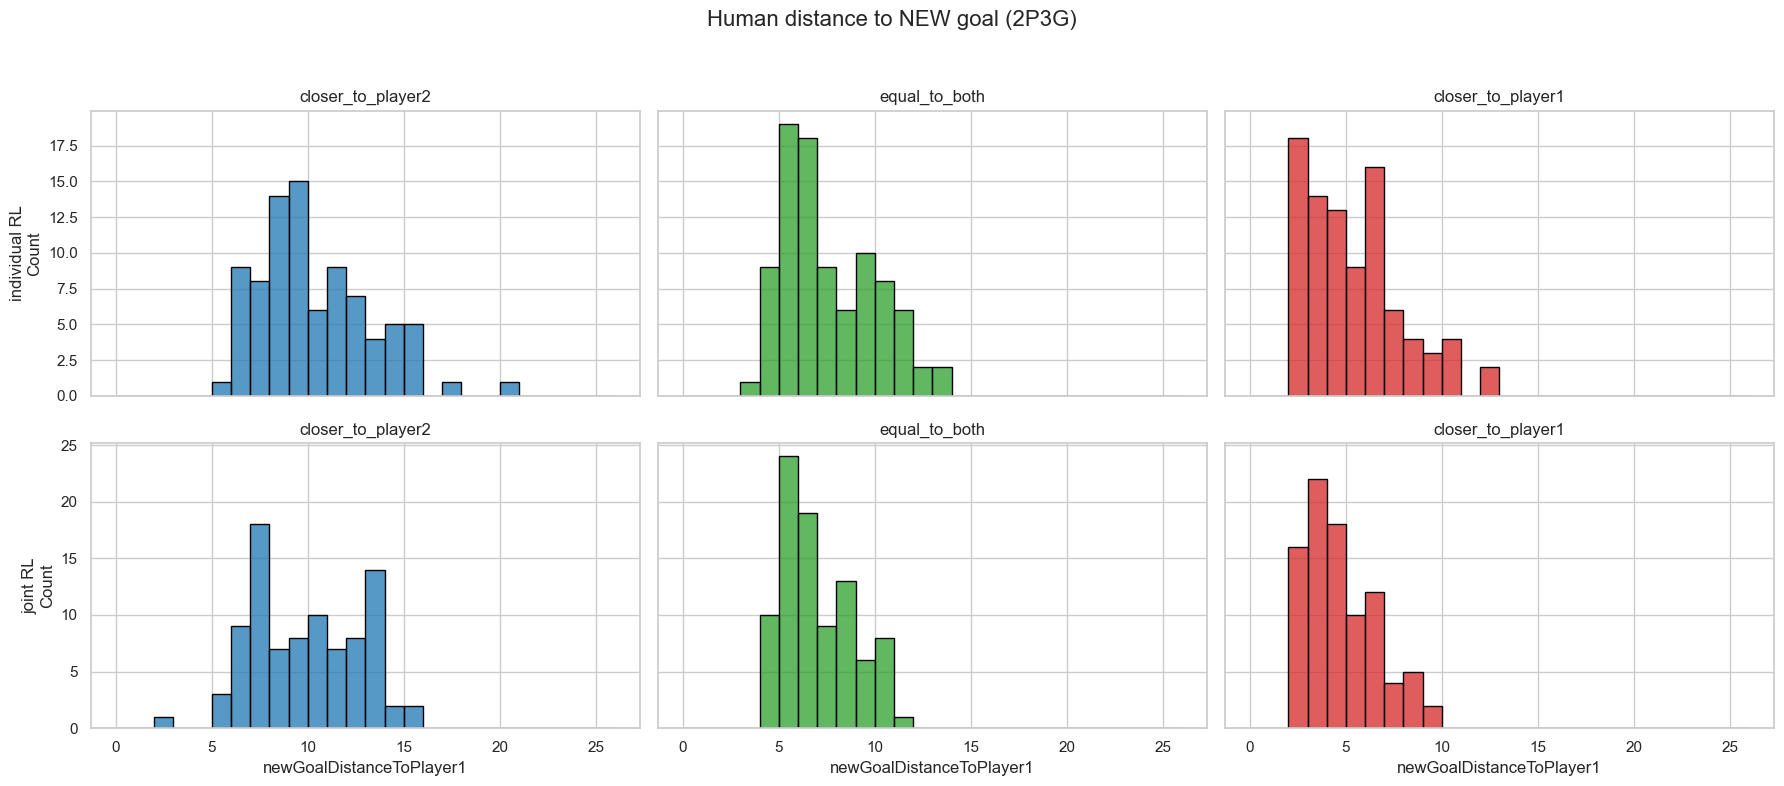

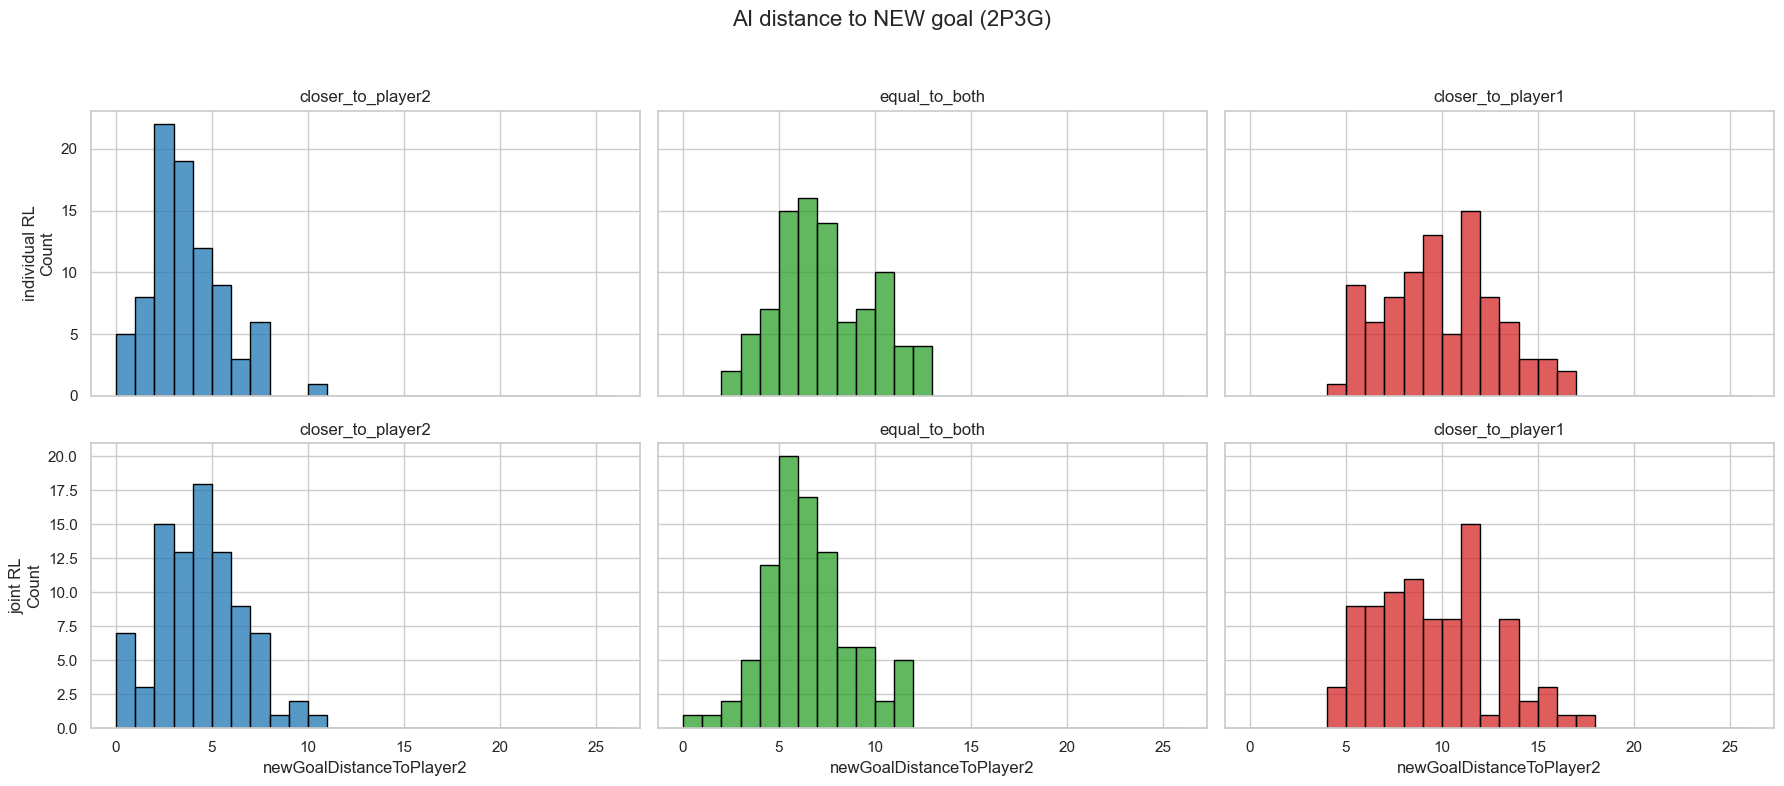

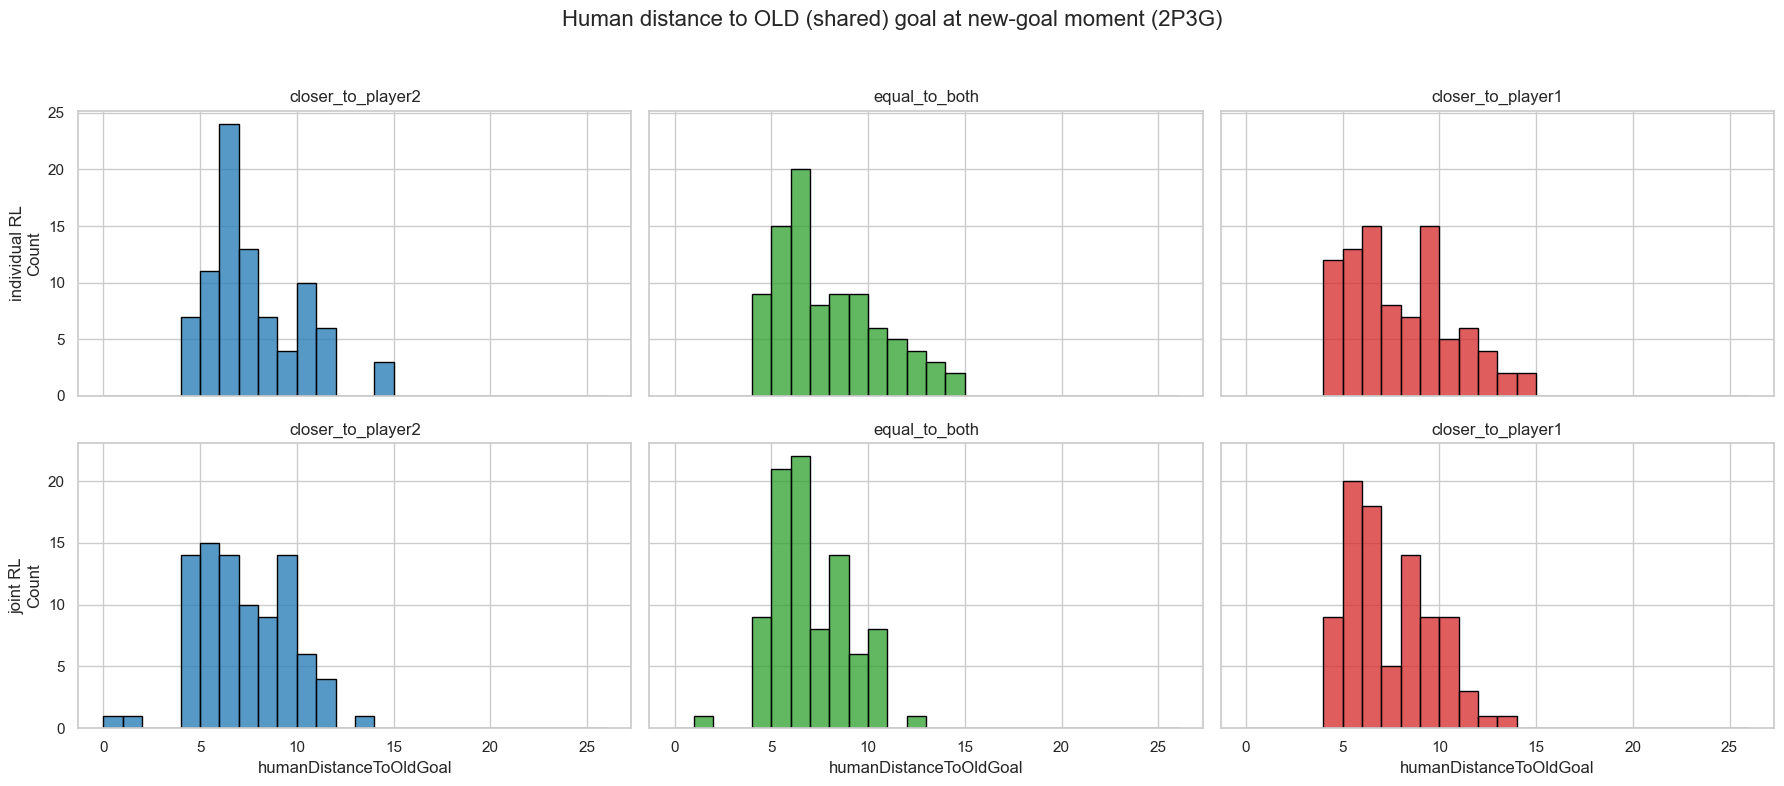

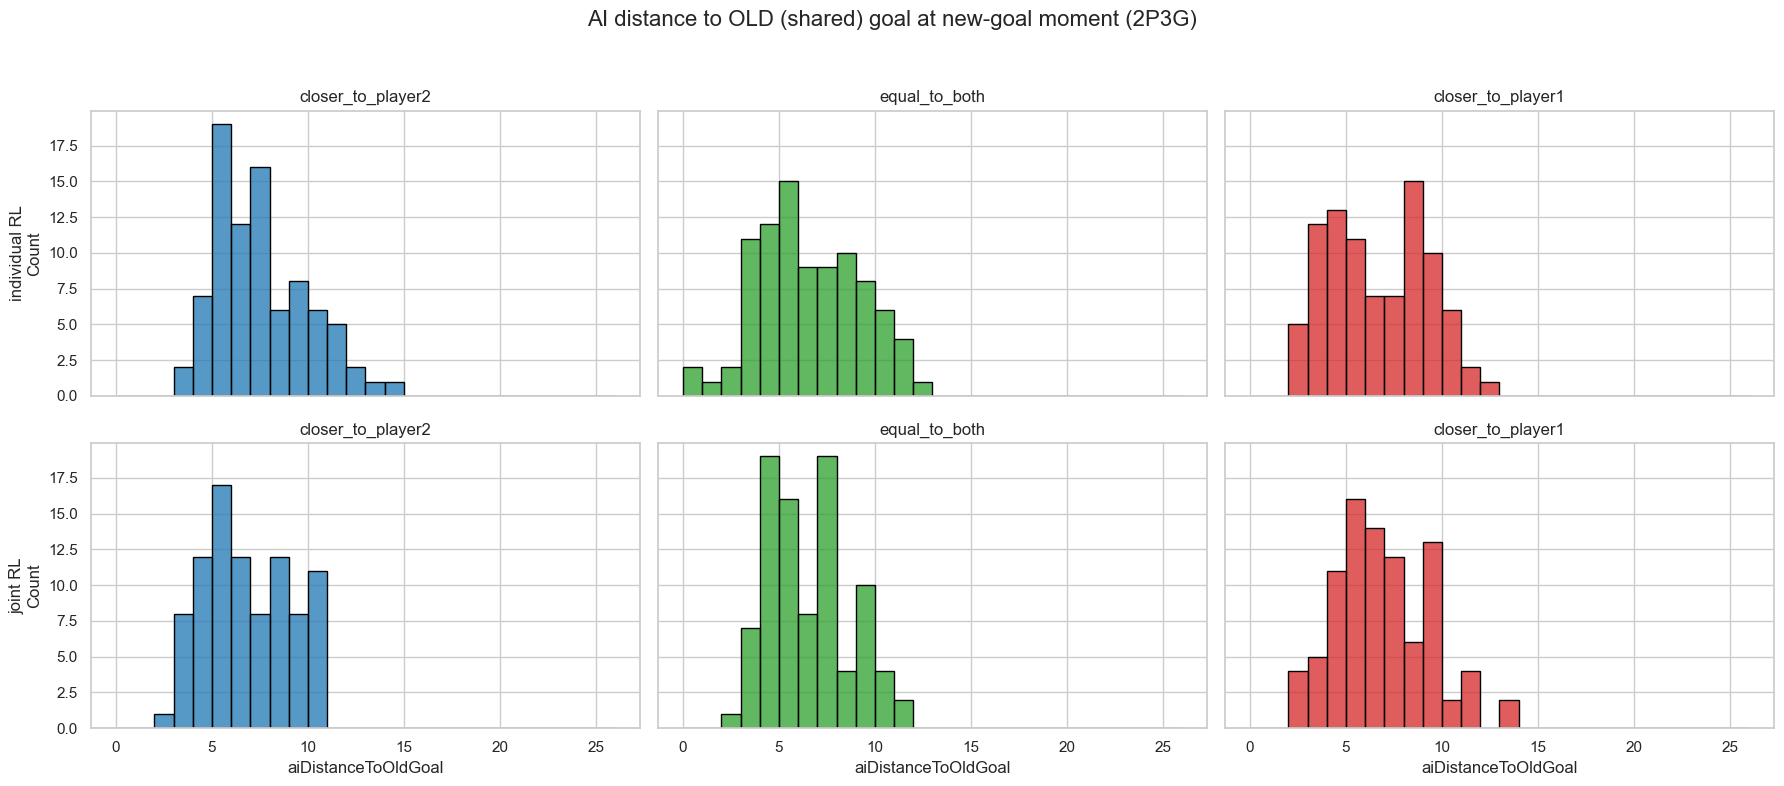

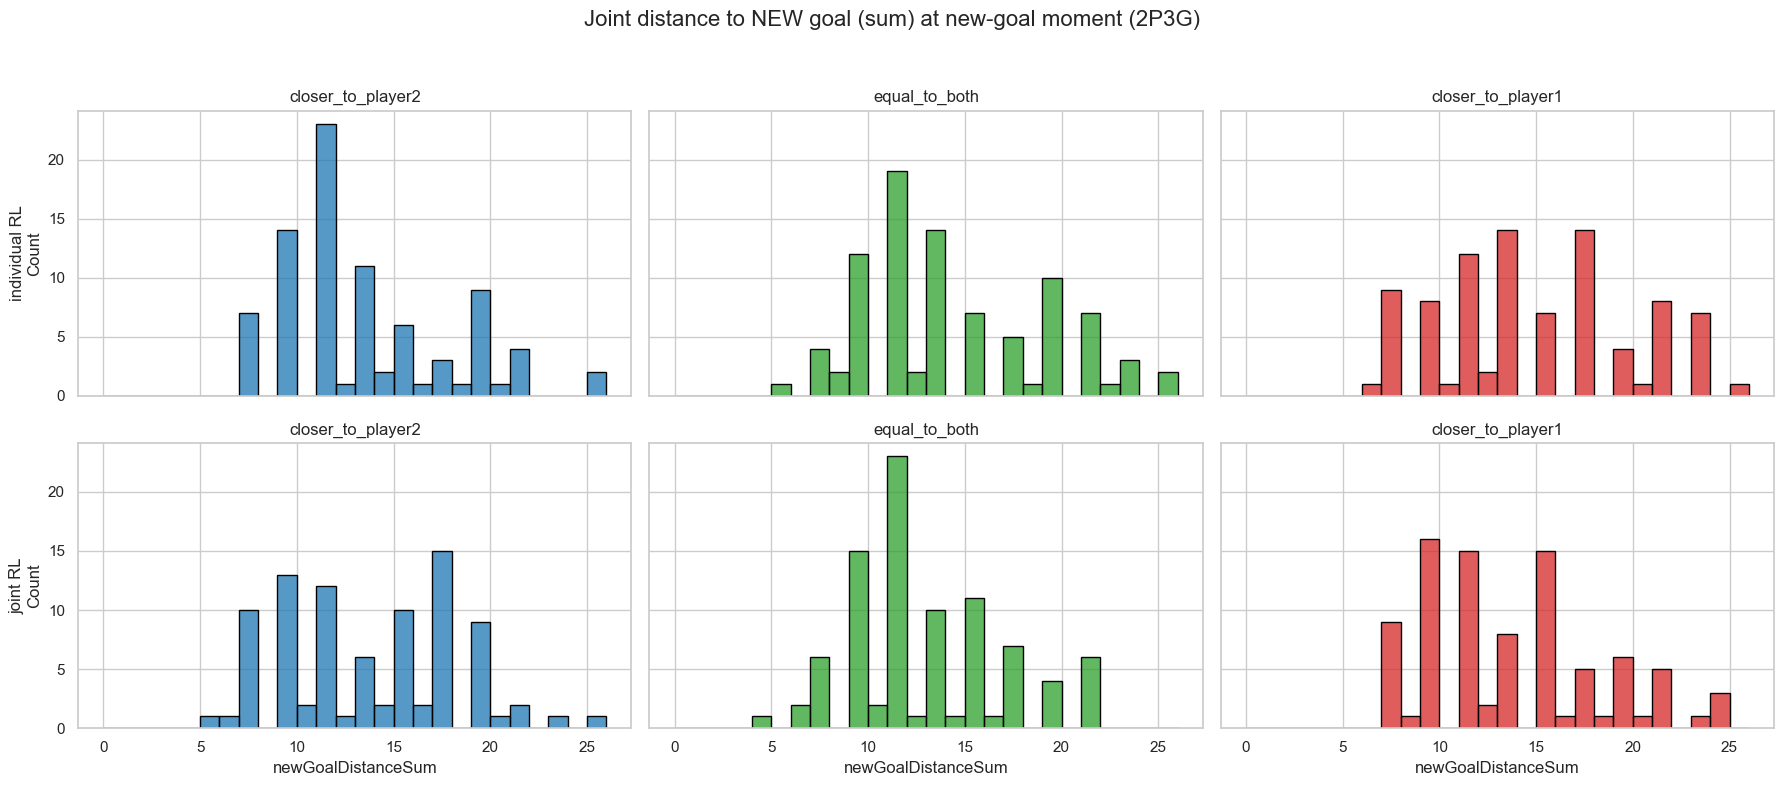

In [15]:
import numpy as np

def plot_grid(var_name, title, bins=None):
    conditions = ['closer_to_player2', 'equal_to_both', 'closer_to_player1']
    rl_types = ['individual', 'joint']
    colors = {
        'closer_to_player2': '#1f77b4',
        'equal_to_both': '#2ca02c',
        'closer_to_player1': '#d62728',
    }
    gdf = plot_df.copy()
    gdf = gdf[pd.notna(gdf[var_name])]
    fig, axes = plt.subplots(len(rl_types), len(conditions), figsize=(18, 8), sharex='col', sharey='row')
    for r, rl in enumerate(rl_types):
        sdf_rl = gdf[gdf['rlAgentType'] == rl]
        for c, cond in enumerate(conditions):
            ax = axes[r, c]
            sdf = sdf_rl[sdf_rl['distanceCondition'] == cond]
            if sdf.empty:
                ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
                ax.set_axis_off()
                continue
            sns.histplot(sdf[var_name], ax=ax, bins=bins, color=colors[cond], edgecolor='black')
            ax.set_title(cond)
            if c == 0:
                ax.set_ylabel(f'{rl} RL\nCount')
            else:
                ax.set_ylabel('')
            if r == len(rl_types) - 1:
                ax.set_xlabel(var_name)
            else:
                ax.set_xlabel('')
    fig.suptitle(title, fontsize=16)
    fig.tight_layout(rect=(0, 0, 1, 0.95))
    return fig

# Choose integer bins up to the max across variables for readability
max_d = int(max(
    plot_df['newGoalDistanceToPlayer1'].max(),
    plot_df['newGoalDistanceToPlayer2'].max(),
    plot_df['humanDistanceToOldGoal'].max(),
    plot_df['aiDistanceToOldGoal'].max(),
    plot_df['newGoalDistanceSum'].max()
))
bins = np.arange(0, max(1, max_d) + 1.5, 1)

plot_grid('newGoalDistanceToPlayer1', 'Human distance to NEW goal (2P3G)', bins)
plot_grid('newGoalDistanceToPlayer2', 'AI distance to NEW goal (2P3G)', bins)
plot_grid('humanDistanceToOldGoal', 'Human distance to OLD (shared) goal at new-goal moment (2P3G)', bins)
plot_grid('aiDistanceToOldGoal', 'AI distance to OLD (shared) goal at new-goal moment (2P3G)', bins)
plot_grid('newGoalDistanceSum', 'Joint distance to NEW goal (sum) at new-goal moment (2P3G)', bins)

## Commitment on joint-distance-neutral trials

Focus on trials where `joint_distance_diff == 0`.
- Human commitment: `player1FirstDetectedGoal == player1FinalReachedGoal`
- AI commitment: `player2FirstDetectedGoal == player2FinalReachedGoal`

We report counts and mean commitment rates overall and by RL type; also the equal_to_both subset.


Human commitment (joint_distance_diff == 0):
  overall: n= 256  rate= 0.6796875
  by RL:                n      rate
rlAgentType               
individual   137  0.613139
joint        119  0.756303
  by RL (equal_to_both):               n      rate
rlAgentType              
individual   35  0.771429
joint        38  0.789474
AI commitment (joint_distance_diff == 0):
  overall: n= 256  rate= 0.67578125
  by RL:                n      rate
rlAgentType               
individual   137  0.620438
joint        119  0.739496
  by RL (equal_to_both):               n      rate
rlAgentType              
individual   35  0.771429
joint        38  0.763158


/var/folders/wb/_15vsjnj26j9fsl6zcs0cphw0000gn/T/ipykernel_63480/660913714.py:116: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=subset_data, x='rlAgentType', y='commitment', hue='agent',
/var/folders/wb/_15vsjnj26j9fsl6zcs0cphw0000gn/T/ipykernel_63480/660913714.py:116: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  sns.barplot(data=subset_data, x='rlAgentType', y='commitment', hue='agent',
/var/folders/wb/_15vsjnj26j9fsl6zcs0cphw0000gn/T/ipykernel_63480/660913714.py:127: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=subset_data, x='rlAgentType', y='commitment', hue='agent',
/var/folders/wb/_15vsjnj26j9fsl6zcs0cphw0000gn/T/ipykernel_63480/660913714.py:127: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'

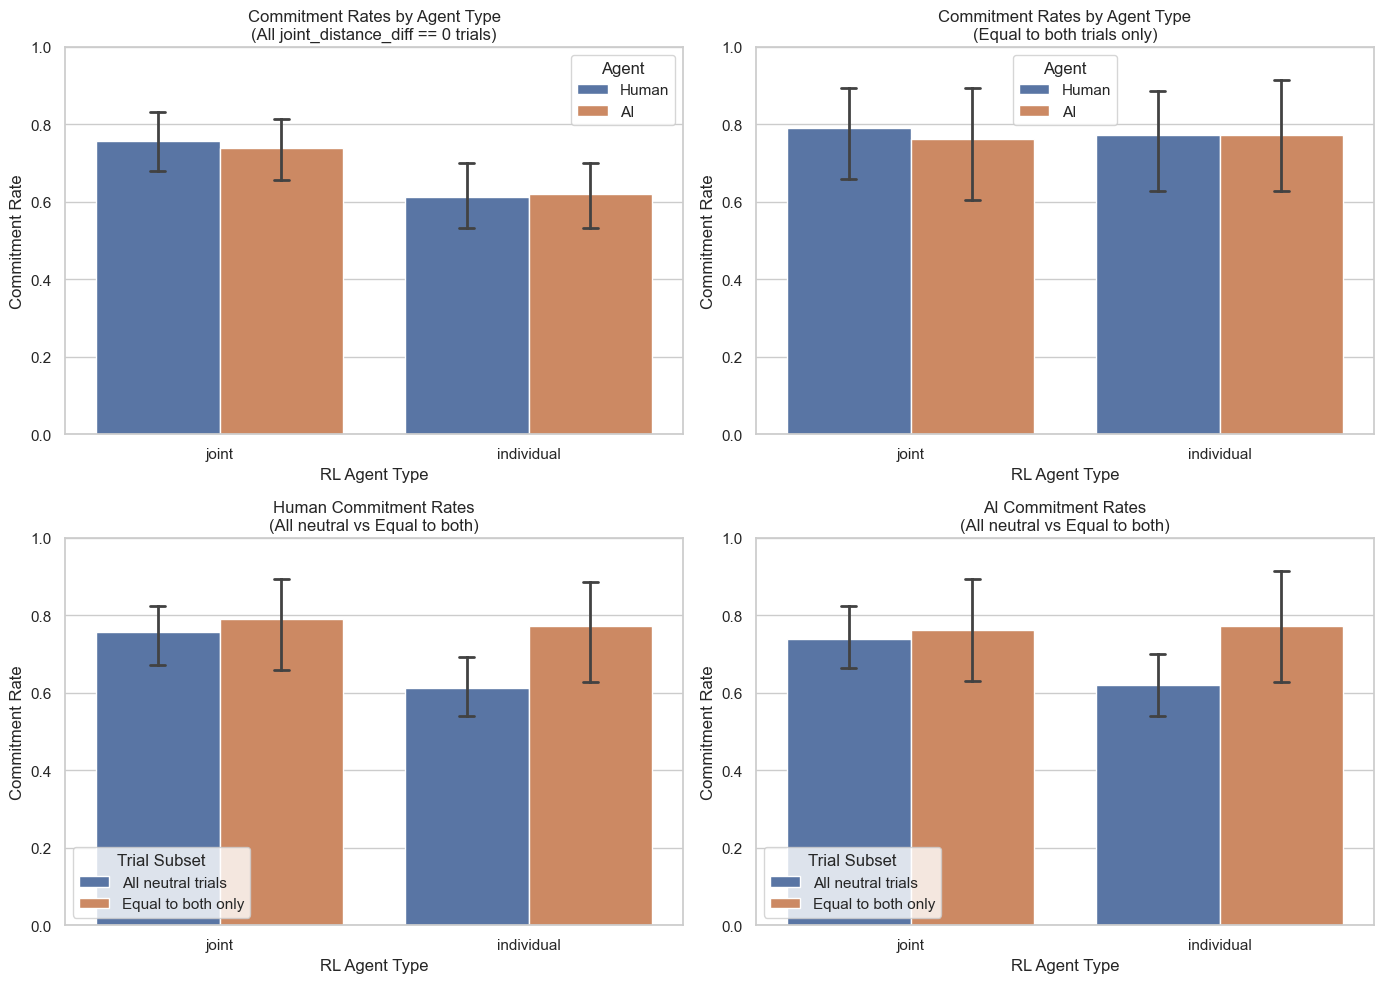

/var/folders/wb/_15vsjnj26j9fsl6zcs0cphw0000gn/T/ipykernel_63480/660913714.py:162: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=plot_df[plot_df['subset'] == 'All neutral trials'],
/var/folders/wb/_15vsjnj26j9fsl6zcs0cphw0000gn/T/ipykernel_63480/660913714.py:162: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  sns.barplot(data=plot_df[plot_df['subset'] == 'All neutral trials'],


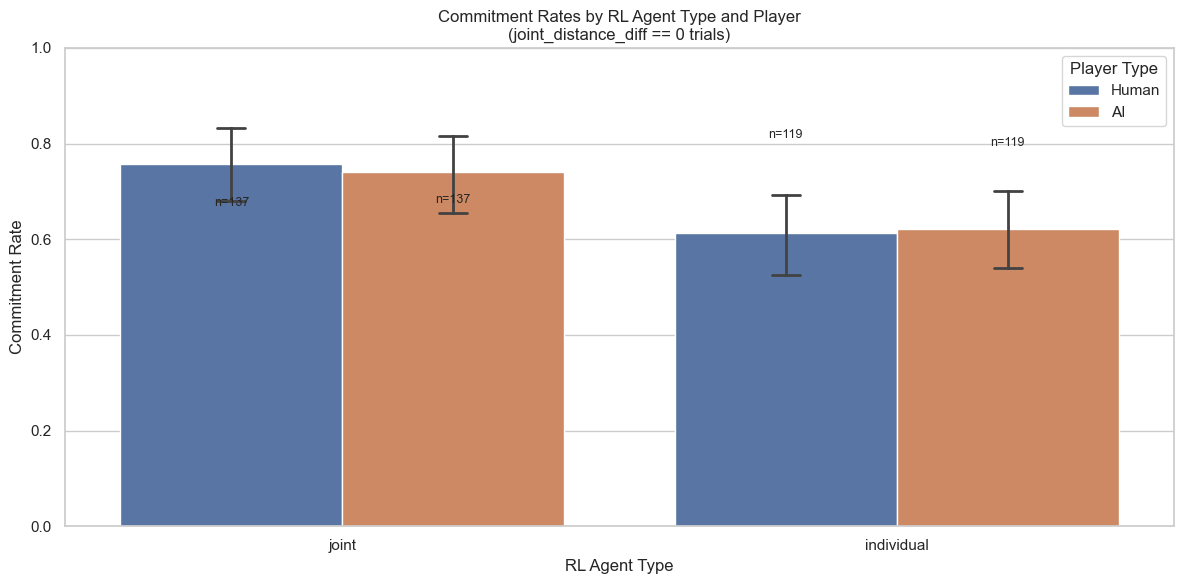

In [16]:
# Ensure joint_distance_diff exists on df
df = df.copy()
df['oldGoalDistanceSum'] = df['humanDistanceToOldGoal'] + df['aiDistanceToOldGoal']
df['joint_distance_diff'] = df['newGoalDistanceSum'] - df['oldGoalDistanceSum']

import numpy as np
import scipy.stats as stats

def _to_int_or_nan(x):
    try:
        return int(x)
    except Exception:
        return np.nan

def commitment_human(row):
    fg = _to_int_or_nan(row.get('firstDetectedSharedGoal'))
    lg = _to_int_or_nan(row.get('player1FinalReachedGoal'))
    if np.isnan(fg) or np.isnan(lg):
        return np.nan
    return 1 if fg == lg else 0

def commitment_ai(row):
    fg = _to_int_or_nan(row.get('firstDetectedSharedGoal'))
    lg = _to_int_or_nan(row.get('player2FinalReachedGoal'))
    if np.isnan(fg) or np.isnan(lg):
        return np.nan
    return 1 if fg == lg else 0

neutral = df[df['joint_distance_diff'] == 0].copy()
neutral['commitment_human'] = neutral.apply(commitment_human, axis=1)
neutral['commitment_ai'] = neutral.apply(commitment_ai, axis=1)

def summarize(comm_col):
    sub = neutral[neutral[comm_col].notna()]
    overall_n = len(sub)
    overall_rate = float(sub[comm_col].mean()) if overall_n else np.nan
    by_rl = (sub.groupby('rlAgentType')[comm_col].agg(['count','mean']).rename(columns={'count':'n','mean':'rate'}))
    eq = sub[sub['distanceCondition']=='equal_to_both']
    by_rl_eq = (eq.groupby('rlAgentType')[comm_col].agg(['count','mean']).rename(columns={'count':'n','mean':'rate'}))
    return overall_n, overall_rate, by_rl, by_rl_eq

hn, hr, h_rl, h_eq = summarize('commitment_human')
an, ar, a_rl, a_eq = summarize('commitment_ai')

print('Human commitment (joint_distance_diff == 0):')
print('  overall: n=', hn, ' rate=', hr)
print('  by RL:', h_rl)
print('  by RL (equal_to_both):', h_eq)
print('AI commitment (joint_distance_diff == 0):')
print('  overall: n=', an, ' rate=', ar)
print('  by RL:', a_rl)
print('  by RL (equal_to_both):', a_eq)

# Prepare data for seaborn plots
plot_data = []

# Add human commitment data
for rl_type in neutral['rlAgentType'].unique():
    subset = neutral[(neutral['rlAgentType'] == rl_type) & (neutral['commitment_human'].notna())]
    for _, row in subset.iterrows():
        plot_data.append({
            'rlAgentType': rl_type,
            'agent': 'Human',
            'commitment': row['commitment_human'],
            'distanceCondition': row['distanceCondition'],
            'subset': 'All neutral trials'
        })

# Add AI commitment data
for rl_type in neutral['rlAgentType'].unique():
    subset = neutral[(neutral['rlAgentType'] == rl_type) & (neutral['commitment_ai'].notna())]
    for _, row in subset.iterrows():
        plot_data.append({
            'rlAgentType': rl_type,
            'agent': 'AI',
            'commitment': row['commitment_ai'],
            'distanceCondition': row['distanceCondition'],
            'subset': 'All neutral trials'
        })

# Add equal_to_both subset data
eq_neutral = neutral[neutral['distanceCondition'] == 'equal_to_both']

# Add human commitment data for equal_to_both
for rl_type in eq_neutral['rlAgentType'].unique():
    subset = eq_neutral[(eq_neutral['rlAgentType'] == rl_type) & (eq_neutral['commitment_human'].notna())]
    for _, row in subset.iterrows():
        plot_data.append({
            'rlAgentType': rl_type,
            'agent': 'Human',
            'commitment': row['commitment_human'],
            'distanceCondition': row['distanceCondition'],
            'subset': 'Equal to both only'
        })

# Add AI commitment data for equal_to_both
for rl_type in eq_neutral['rlAgentType'].unique():
    subset = eq_neutral[(eq_neutral['rlAgentType'] == rl_type) & (eq_neutral['commitment_ai'].notna())]
    for _, row in subset.iterrows():
        plot_data.append({
            'rlAgentType': rl_type,
            'agent': 'AI',
            'commitment': row['commitment_ai'],
            'distanceCondition': row['distanceCondition'],
            'subset': 'Equal to both only'
        })

plot_df = pd.DataFrame(plot_data)

# Create plots using seaborn with 95% CI error bars
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: All neutral trials - Human vs AI by RL type
ax1 = axes[0, 0]
subset_data = plot_df[plot_df['subset'] == 'All neutral trials']
sns.barplot(data=subset_data, x='rlAgentType', y='commitment', hue='agent',
           ax=ax1, ci=95, capsize=0.1, errwidth=2)
ax1.set_title('Commitment Rates by Agent Type\n(All joint_distance_diff == 0 trials)')
ax1.set_ylabel('Commitment Rate')
ax1.set_xlabel('RL Agent Type')
ax1.set_ylim(0, 1)
ax1.legend(title='Agent')

# Plot 2: Equal to both only - Human vs AI by RL type
ax2 = axes[0, 1]
subset_data = plot_df[plot_df['subset'] == 'Equal to both only']
sns.barplot(data=subset_data, x='rlAgentType', y='commitment', hue='agent',
           ax=ax2, ci=95, capsize=0.1, errwidth=2)
ax2.set_title('Commitment Rates by Agent Type\n(Equal to both trials only)')
ax2.set_ylabel('Commitment Rate')
ax2.set_xlabel('RL Agent Type')
ax2.set_ylim(0, 1)
ax2.legend(title='Agent')

# Plot 3: Human commitment comparison between subsets
ax3 = axes[1, 0]
human_data = plot_df[plot_df['agent'] == 'Human']
sns.barplot(data=human_data, x='rlAgentType', y='commitment', hue='subset',
           ax=ax3, ci=95, capsize=0.1, errwidth=2)
ax3.set_title('Human Commitment Rates\n(All neutral vs Equal to both)')
ax3.set_ylabel('Commitment Rate')
ax3.set_xlabel('RL Agent Type')
ax3.set_ylim(0, 1)
ax3.legend(title='Trial Subset')

# Plot 4: AI commitment comparison between subsets
ax4 = axes[1, 1]
ai_data = plot_df[plot_df['agent'] == 'AI']
sns.barplot(data=ai_data, x='rlAgentType', y='commitment', hue='subset',
           ax=ax4, ci=95, capsize=0.1, errwidth=2)
ax4.set_title('AI Commitment Rates\n(All neutral vs Equal to both)')
ax4.set_ylabel('Commitment Rate')
ax4.set_xlabel('RL Agent Type')
ax4.set_ylim(0, 1)
ax4.legend(title='Trial Subset')

plt.tight_layout()
plt.show()

# Create a comprehensive comparison plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.barplot(data=plot_df[plot_df['subset'] == 'All neutral trials'],
           x='rlAgentType', y='commitment', hue='agent',
           ax=ax, ci=95, capsize=0.1, errwidth=2)
ax.set_title('Commitment Rates by RL Agent Type and Player\n(joint_distance_diff == 0 trials)')
ax.set_ylabel('Commitment Rate')
ax.set_xlabel('RL Agent Type')
ax.set_ylim(0, 1)
ax.legend(title='Player Type')

# Add sample size annotations
for i, rl_type in enumerate(['individual', 'joint']):
    # Human data
    human_subset = neutral[(neutral['rlAgentType'] == rl_type) & (neutral['commitment_human'].notna())]
    human_n = len(human_subset)
    human_rate = human_subset['commitment_human'].mean() if human_n > 0 else 0

    # AI data
    ai_subset = neutral[(neutral['rlAgentType'] == rl_type) & (neutral['commitment_ai'].notna())]
    ai_n = len(ai_subset)
    ai_rate = ai_subset['commitment_ai'].mean() if ai_n > 0 else 0

    # Add text annotations
    ax.text(i - 0.2, human_rate + 0.05, f'n={human_n}', ha='center', va='bottom', fontsize=9)
    ax.text(i + 0.2, ai_rate + 0.05, f'n={ai_n}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


## Commitment when AI old == AI new distance

Filter trials where `aiDistanceToOldGoal == newGoalDistanceToPlayer2` and plot commitment rates for human and AI.
- Human commitment: `player1FirstDetectedGoal == player1FinalReachedGoal`
- AI commitment: `player2FirstDetectedGoal == player2FinalReachedGoal`

We show bar plots of mean commitment by distance condition (x) and RL agent type (hue).


Trials with ai old == ai new distance AND equal distance sums: 54


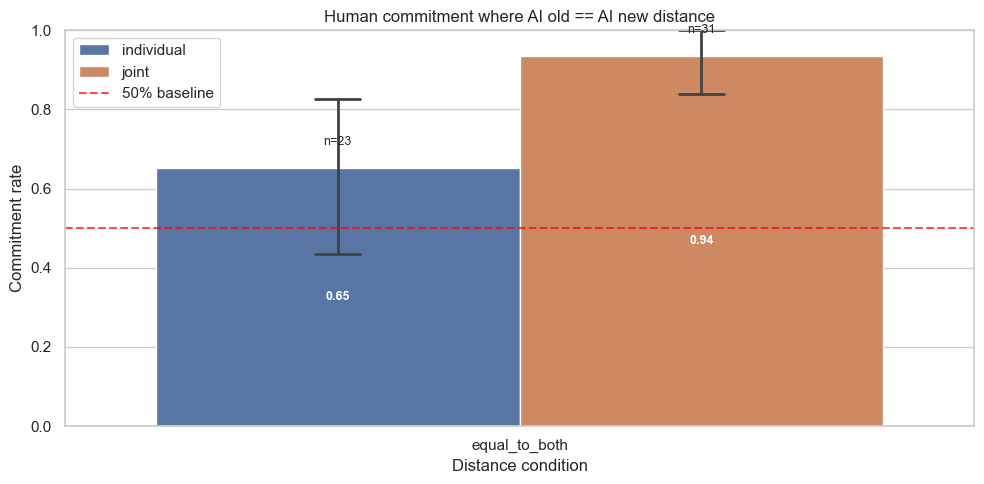

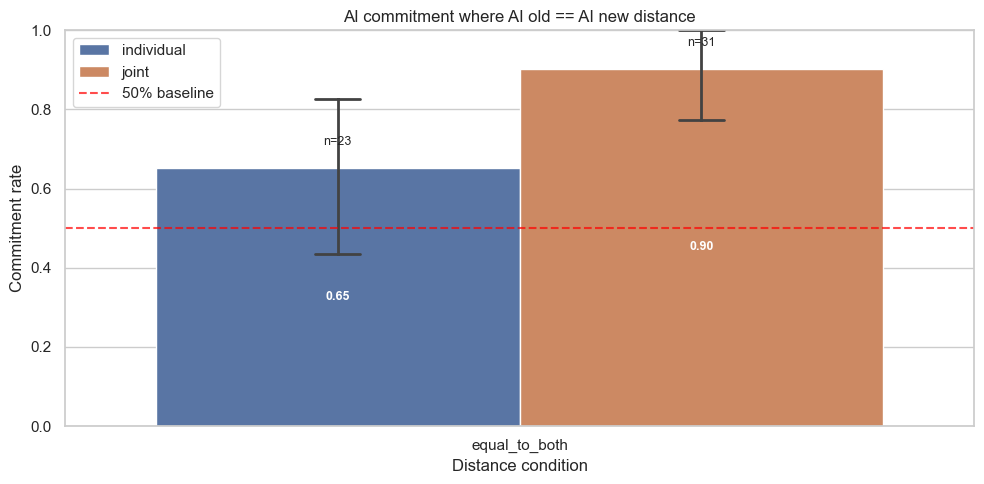

In [23]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Work on a copy of df which includes original columns
df_commit = df.copy()
# Filter where AI distance to old equals AI distance to new (exact)
mask_equal = (df_commit['aiDistanceToOldGoal'] == df_commit['newGoalDistanceToPlayer2'])
# Additional filter: new goal distance sum equals old goal distance sum
mask_sum_equal = (df_commit['newGoalDistanceSum'] == df_commit['oldGoalDistanceSum'])
eq_df = df_commit[mask_equal & mask_sum_equal].copy()
print(f'Trials with ai old == ai new distance AND equal distance sums: {len(eq_df)}')

def _to_int_or_nan(x):
    try:
        return int(x)
    except Exception:
        return np.nan

def commitment_human(row):
    fg = _to_int_or_nan(row.get('player1FirstDetectedGoal'))
    lg = _to_int_or_nan(row.get('player1FinalReachedGoal'))
    if np.isnan(fg) or np.isnan(lg):
        return np.nan
    return 1 if fg == lg else 0

def commitment_ai(row):
    fg = _to_int_or_nan(row.get('player2FirstDetectedGoal'))
    lg = _to_int_or_nan(row.get('player2FinalReachedGoal'))
    if np.isnan(fg) or np.isnan(lg):
        return np.nan
    return 1 if fg == lg else 0

eq_df['commitment_human'] = eq_df.apply(commitment_human, axis=1)
eq_df['commitment_ai'] = eq_df.apply(commitment_ai, axis=1)

# Prepare grouped summaries
def barplot_commitment(data, col, title):
    sub = data[data[col].notna()].copy()
    if sub.empty:
        print(f'No valid commitment data for {col}')
        return

    fig, ax = plt.subplots(figsize=(10,5))
    sns.barplot(data=sub, x='distanceCondition', y=col, hue='rlAgentType',
                errorbar=('ci', 95), capsize=0.1, err_kws={'linewidth': 2}, ax=ax)
    ax.set_ylim(0,1)
    ax.set_title(title)
    ax.set_ylabel('Commitment rate')
    ax.set_xlabel('Distance condition')

    # Add 50% baseline
    ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='50% baseline')
    ax.legend()

    # Add sample size annotations and values
    distance_conditions = sub['distanceCondition'].unique()
    rl_types = sub['rlAgentType'].unique()

    for i, dist_cond in enumerate(distance_conditions):
        for j, rl_type in enumerate(rl_types):
            subset = sub[(sub['distanceCondition'] == dist_cond) & (sub['rlAgentType'] == rl_type)]
            n = len(subset)
            if n > 0:
                mean_val = subset[col].mean()
                # Position text above the bar
                x_pos = i + (j - 0.5) * 0.4  # Adjust position based on hue
                ax.text(x_pos, mean_val + 0.05, f'n={n}', ha='center', va='bottom', fontsize=9)
                ax.text(x_pos, mean_val/2, f'{mean_val:.2f}', ha='center', va='center', fontsize=9, fontweight='bold', color='white')

    plt.tight_layout()

barplot_commitment(eq_df, 'commitment_human', 'Human commitment where AI old == AI new distance')
barplot_commitment(eq_df, 'commitment_ai', 'AI commitment where AI old == AI new distance')


## Strict Filter + Human Commitment by Distance per Experiment (2P3G)

Apply requested filtering before analysis:
- Keep only trials where joint distance to NEW equals joint distance to ORIGINAL intended goal (`joint_distance_diff == 0`).
- Additionally, for `equal_to_both`, require per-player equality: `newGoalDistanceToPlayer1 == humanDistanceToOldGoal` AND `newGoalDistanceToPlayer2 == aiDistanceToOldGoal`.

Then compute human commitment across the four distance conditions in 2P3G, broken down by experiment group (auto-detected column with 4 unique values if present).

In [ ]:
# Strictly filtered neutral set
neutral_strict = neutral.copy()
eq_mask = neutral_strict['distanceCondition'] == 'equal_to_both'
eq_ok = (neutral_strict['newGoalDistanceToPlayer1'] == neutral_strict['humanDistanceToOldGoal']) & (neutral_strict['newGoalDistanceToPlayer2'] == neutral_strict['aiDistanceToOldGoal'])
neutral_strict = neutral_strict[(~eq_mask) | eq_ok].copy()

print(f"Strict-neutral trials kept: {len(neutral_strict)} (of {len(neutral)})")
if (neutral_strict['distanceCondition'] == 'equal_to_both').any():
    kept_eq = int((neutral_strict['distanceCondition'] == 'equal_to_both').sum())
    print(f"  equal_to_both kept after per-player check: {kept_eq}")

# Pick experiment column
candidate_cols = ['experimentName','experiment','experiment_id','experimentId','study','studyType','study_name','file_id','source_file','game_type','gameClass','game_class','rlAgentType']
experiment_col = None
for c in candidate_cols:
    if c in neutral_strict.columns:
        nun = int(neutral_strict[c].nunique(dropna=True))
        if nun == 4:
            experiment_col = c
            break
if experiment_col is None:
    for c in candidate_cols:
        if c in neutral_strict.columns:
            experiment_col = c
            break
if experiment_col is None and 'rlAgentType' in neutral_strict.columns:
    experiment_col = 'rlAgentType'
print(f"Using experiment column: {experiment_col}")
print(f"Unique experiment groups: {sorted(list(neutral_strict[experiment_col].dropna().unique()))}")

# Human commitment per distance condition, per experiment
def _to_int_or_nan(x):
    try:
        return int(x)
    except Exception:
        return np.nan

def commitment_human_only(row):
    fg = _to_int_or_nan(row.get('firstDetectedSharedGoal'))
    lg = _to_int_or_nan(row.get('player1FinalReachedGoal'))
    if np.isnan(fg) or np.isnan(lg):
        return np.nan
    return 1 if fg == lg else 0

neutral_strict['human_commitment'] = neutral_strict.apply(commitment_human_only, axis=1)
sub = neutral_strict.dropna(subset=['human_commitment']).copy()
summary = (sub.groupby([experiment_col, 'distanceCondition'])['human_commitment'].agg(['count','mean']).rename(columns={'count':'n','mean':'commitment_rate'}).reset_index())
print("\nHuman commitment by distance condition per experiment group (strict filter):")
print(summary)

# Plot
try:
    plt.figure(figsize=(12,6))
    sns.barplot(data=summary, x='distanceCondition', y='commitment_rate', hue=experiment_col, errorbar=('ci',95))
    plt.ylim(0,1)
    plt.title('Human commitment (2P3G) by distance condition — strict neutral filter')
    plt.ylabel('Commitment rate')
    plt.xlabel('Distance condition')
    plt.legend(title=experiment_col)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f'Plotting skipped: {e}')
